In [ ]:
%matplotlib inline


PyTrorch 모델로부터 ONNX Runtime 실행하기
========================================================================
본 노트북은 아래 링크에 대한 한글 번역입니다.
- 소스 : https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html
- SageMaker 노트북에서 실행할 경우 커널을 `conda_pytorch_p36`으로 설정하십시오.

본 예제는 PyTorch로 작성된 모델을 어떻게 ONNX 형식으로 변환하고 ONNX 런타임에서 실행할 수 있을지에 대해 다룹니다. 

ONNX 런타임은 ONNX 모델을 위한 실행엔진이며, Windows, Linux, Mac 그리고 GPU와 GPU 등 다양한 환경에서 추론을 실행합니다.  
ONNX 런타임은 다음 링크에서 설명된 바와 같이 다양한 모델에 대하여 주목할 만한 성능향상을 보여주고 있습니다.

ONNX Runtime is a performance-focused engine for ONNX models,
which inferences efficiently across multiple platforms and hardware
(Windows, Linux, and Mac and on both CPUs and GPUs).
ONNX Runtime has proved to considerably increase performance over
multiple models as explained
- https://cloudblogs.microsoft.com/opensource/2019/05/22/onnx-runtime-machine-learning-inferencing-0-4-release

본 예제에서 우리는 ONNX(https://github.com/onnx/onnx )와 ONNX 런타임(https://github.com/microsoft/onnxruntime )을 설치하고 다음 명령을 이용하여 바이너리를 확보할 것입니다.  
``pip install onnx onnxruntime``   
ONNX 런타임은 파이썬 버전 3.5부터 3.7에서 호환되는 점을 기억하십시오. 

``NOTE``: 본 튜토리얼은 PyTorch master branch가 필요하며 아래 가이드에 따라 설치할 수 있습니다. 
- https://github.com/pytorch/pytorch#from-source




### 작업준비(환경설정)

In [8]:
!pip install onnx onnxruntime

     |████████████████████████████████| 4.4 MB 10.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

### PyTorch 모델 생성

슈퍼 해상도(Super-resolution) 는 이미지와 비디오의 해상도를 향상시키는 방식을 말하며, 이미지 프로세싱과 비디오 편집 등에서 광범위하게 사용됩니다. 본 예제에서 우리는 작은 슈퍼해상도 모델을 사용할 것입니다.

처음으로, PyTorch로 슈퍼해상도 모델을 만들어봅니다. 이 모델은 업스케일된 항목(factor)에 의해 이미지의 해상도를 증가시키기 위하여 다음 논문에 소개된 내용과 같이 효율적인 서브픽셀 컨볼루션 레이어(sub-pixel convolution layer)를 사용합니다.
- `"Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network" - Shi et al <https://arxiv.org/abs/1609.05158>`

이 모델은 이미지의 YCbCr의 Y 요소를 입력으로 업스케일된 Y 요소를 슈퍼해상도의 출력으로 기대합니다.  
모델은 다음 예제로 부터 변형없이 사용되었습니다. 
- `<https://github.com/pytorch/examples/blob/master/super_resolution/model.py>`__




In [2]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

일반적으로는 이 모델을 이용하여 학습을 실행할 것입니다. 하지만 본 예제에서는 대신 사전 학습된 (pre-trained) 가중치를 다운로드받아 사용할 것입니다. 다운받는 모델은 데모를 목적으로 하며, 최고의 정확도를 위해 완전히 학습된 상태는 아닙니다. 

모델을 추출(export)하기 전에 모델을 초론 모드로 바꾸기 위해 ``torch_model.eval()`` 또는 ``torch_model.train(False)``명령을 실행하는 것이 중요합니다. 이 변경은 dropout이나 batchnorm과 같은 실행이 학습모드와는 다르게 동작하도록 하기 위해 필요합니다. 


In [3]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

Downloading: "https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth" to /home/ec2-user/.cache/torch/checkpoints/superres_epoch100-44c6958e.pth


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

### PyTorch 모델 추출 

PyTorch에서 모델 추출(export)은 추적(tracing) 또는 스크립팅(scripting)을 통해 동작합니다. 이 튜토리얼은 tracing을 활용한 모델 추출을 사용할 것입니다.
모델을 추출하기 위해 ``torch.onnx.export()`` 함수를 호출합니다.
이 함수는 모델을 실행하고 연산결과물을 계산하기 위해 실행한 연산들의 추적(tracing)을 기록합니다.
``export``명령은 모델을 실행(run)하기 때문에 Tensor로 입력되는 ``x`` 값을 제공해야 합니다. 이 값은 데이터의 타입과 크기가 맞다면 랜덤 값으로 입력되어도 상관없습니다.
데이터 입력 차원의 크기는 dynamic axes로 정의된 것이 아니라면 추출된 ONNX 그래프에 따라 고정됩니다. 
본 예제에서 우리는 batch_size를 1로 모델을 추출하지만 ``torch.onnx.export()``에서 첫번째 차원을 ``dynamic axes``로 지정하습니다.
따라서 추출된 모델은 bach_size를 변수로 처리하여 입력 크기를 [batch_size, 1, 224, 224] 와 같이 받게 될 것입니다.

PyTorch의 추출 인터페이스와 관련하여 보다 자세한 내용은 아래 링크를 참고하십시오.
- `torch.onnx documentation <https://pytorch.org/docs/master/onnx.html>`__.


In [4]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

### 출력된 모델 로드하기

우리는 또한 모델의 실행 결과로 ``torch_out``을 계산할 것이며, 이는 ONNX 런타임에서도 동일한 결과를 생성하는지에 대한 검증 용도로 사용할 것입니다.

하지만 ONNX 런타임에서 모델의 출력을 검증하기 전에 ONNX API를 이용하여 ONNX 모델을 체크할 것입니다.

먼저, ``onnx.load("super_resolution.onnx")`` 명령은 저장된 모델을 로드하고 onnx.ModelProto구조 (ML모델을 번들링하기 위한 최상위 파일/컨테이너 형식)를 출력으로 리턴합니다. 
- 자세한 내용은 다음을 참고합니다.  `onnx.proto documentation <https://github.com/onnx/onnx/blob/master/onnx/onnx.proto>`

그 다음, ``onnx.checker.check_model(onnx_model)`` 명령은 모델의 구조를 점검하고 적절한 스키마를 가지고 있는 지 확인할 것입니다.
ONNX 그래프의 유효성(validity)은 모델의 버전, 그래프 구조, 그리고 입출력 노드를 체크하면서 검증됩니다. 


In [5]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

이제 ONNX 런타임의 파이썬 API를 사용하여 출력을 계산해보겠습니다. 이 부분은 보통 다른 머신에서 별도의 프로세스로 실행될 것이지만, 본 예제에서는 ONNX런타임을 검증하고 PyTorch가 동일한 값을 생성하는지 확인하기 위해 동일 프로세스에서 실행하겠습니다. 

모델을 ONNX 런타임에서 실행하기 위해, 우리는 주어진 설정 파라미터를 이용하여 (본 예제에서는 디폴트 사용) 추론 세션을 생성해야 합니다. 세션은 한 번 생성되면 run() API를 이용하여 모델을 평가할 수 있게 됩니다. run()호출의 결과는 ONNX런타임에서 모델이 실행된 결과를 가진 리스트입니다. 

In [9]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [24]:
ort_outs

[array([[[[0.1594826 , 0.18392749, 0.18281619, ..., 0.49523917,
           0.45997566, 0.4098967 ],
          [0.17893156, 0.2720161 , 0.27031672, ..., 0.6387107 ,
           0.60963386, 0.46842197],
          [0.2225707 , 0.2698424 , 0.26362202, ..., 0.6487816 ,
           0.63083017, 0.47454762],
          ...,
          [0.5923772 , 0.66714346, 0.6872308 , ..., 0.7169886 ,
           0.72955894, 0.5931575 ],
          [0.54163   , 0.6098734 , 0.6267196 , ..., 0.68617743,
           0.6901655 , 0.57968223],
          [0.49894172, 0.50799745, 0.5031805 , ..., 0.53756183,
           0.54927623, 0.5178513 ]]]], dtype=float32)]

우리는 PyTorch와 ONNX 런타임의 결과는 주어진 정확도(precision)내에서 일치합니다.   
(만약 이 결과가 일치하지 않으면 ONNX 추출에 이슈가 있었음을 의미하며 별도 확인이 필요합니다.)

### 다른 이미지로 ONNX 런타임 모델 실행하기


여기까지 우리는 PyTorch 모델을 추출하고  임의의 입력 tensor에 대해 어떻게 다시 이를 ONNX 런타임에서 로드하여 실행하는지 살펴보았다. 

이번 단계에서는 다음 고양이 이미지를 이용하여 테스트를 해보자. 


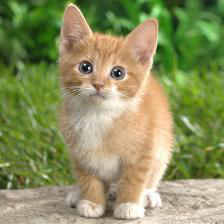

In [26]:
from PIL import Image
import torchvision.transforms as transforms

# img = Image.open("./_static/img/cat.jpg")
img = Image.open("cat.jpg")
img

다음으로 이미지를 로드하고 이미지처리의 표준처럼 사용되는 PIL 라이브러리를 이용하여 전처리를 하자. 이런 전처리는 신경망의 학습과 테스트에서 표준적인 과정이다. 

- 처음으로, 이미지를 모델의 입력(224x224)에 맞도록 리사이징 하였다.
- 다음으로 이미지를 Y, Cb, Cr 요소로 분리한다. (Y: grayscale image, Cb: blue-difference, Cr: red-difference)
- Y요소는 사람의 시각에 보다 민감하기 때문에 변형시 이 값에 보다 주목할 것이다. Y값을 추출한 이후에는 이를 모델 입력을 위한 tensor로 변환한다. 


In [12]:
resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)

tensor([[[[0.2157, 0.1961, 0.1922,  ..., 0.5294, 0.5569, 0.5725],
          [0.2039, 0.1922, 0.1922,  ..., 0.5333, 0.5529, 0.5686],
          [0.2000, 0.1843, 0.1843,  ..., 0.5216, 0.5373, 0.5490],
          ...,
          [0.6667, 0.6745, 0.6392,  ..., 0.6902, 0.6667, 0.6078],
          [0.6392, 0.6431, 0.6235,  ..., 0.8000, 0.7608, 0.6745],
          [0.6392, 0.6353, 0.6510,  ..., 0.8118, 0.7686, 0.6667]]]])

이제 다음 단계로 리사이즈된 grayscale 고양이 이미지 tensor를 이용하여 ONNX 런타임에서 실행중인 슈퍼해상도 모델을 실행해 보자. 


In [20]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

여기서 모델의 출력은 tensor이다. 
이제 우리는 이 출력 tensor로부터 출력 이미지를 생성하고 이를 파일로 저장할 것이다. 
본 후처리 프로세스는 다음 슈퍼해상도 모델의 PyTorch 구현에서 확인할 수 있다. 
- `here <https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py>`__.




In [21]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Save the image, we will compare this with the output image from mobile device
final_img.save("cat_superres_with_ort.jpg")

.. figure:: /_static/img/cat_superres_with_ort.jpg
   :alt: output\_cat


플랫폼간 호환(cross) 엔진인 ONNX 런타임을 이용하여 CPU, GPU를 지원하는 다양한 플랫폼에서 모델을 실행할 수 있다. 
그리고 ONNX 런타임은 Azure 등 클라우드에서도 실행가능하며 보다 자세한 내용은 다음을 참조할 수 있다. 
- https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-onnx
- https://github.com/microsoft/onnxruntime#high-performance
- https://github.com/microsoft/onnxruntime


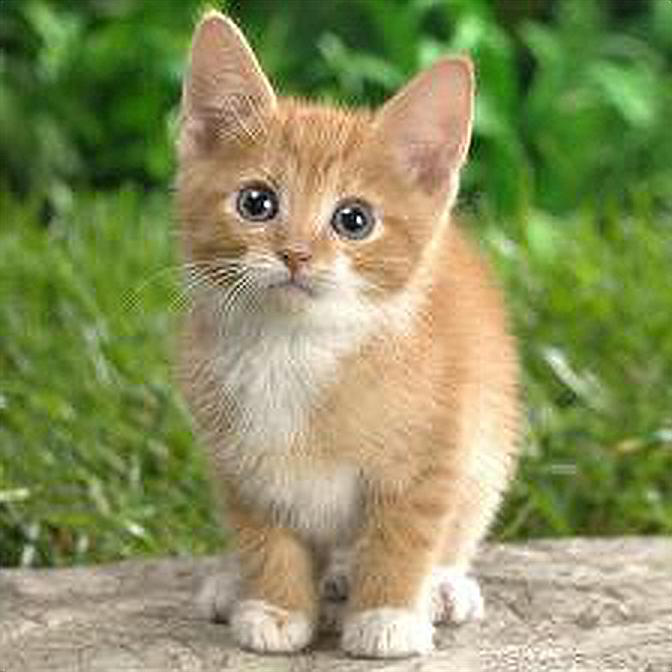

In [22]:
Image.open("cat_superres_with_ort.jpg")